In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
import seaborn as sns

Lets makes some dates

In [4]:
df = pd.read_csv("blockdetails.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
#df['seconds'] = df['timestamp'].apply(lambda row : row)
df['hour'] = df.timestamp.dt.hour
df['minute'] = df.timestamp.dt.minute
df['second'] = df.timestamp.dt.second
df['date'] = df.timestamp.dt.date
df.blockTime = pd.to_numeric(df.blockTime, errors='coerce')
df = df.rename(index=str, columns={"number":"blockNumber"})
df = df.iloc[1:]

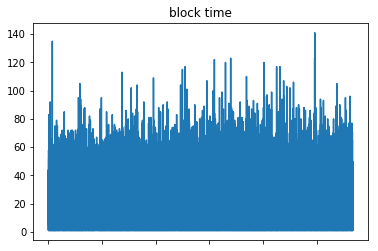

In [5]:
ax = df.blockTime.plot.line(title='block time')
plt.show()

Let's look at blocks per minute and do a correlation heatmap to see if there are any relationships.

/home/andre/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


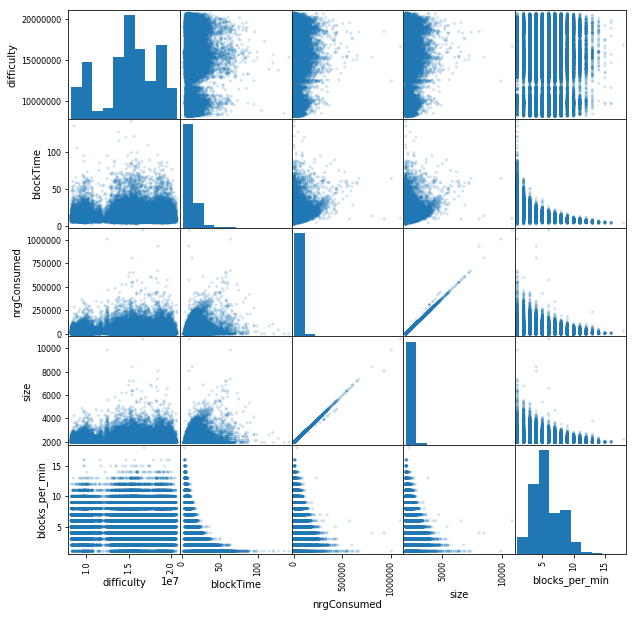

                difficulty  blockTime  nrgConsumed      size  blocks_per_min
difficulty        1.000000   0.021256    -0.012392 -0.012863       -0.005663
blockTime         0.021256   1.000000     0.255602  0.255754       -0.694703
nrgConsumed      -0.012392   0.255602     1.000000  0.999606       -0.196561
size             -0.012863   0.255754     0.999606  1.000000       -0.196798
blocks_per_min   -0.005663  -0.694703    -0.196561 -0.196798        1.000000


In [6]:
df_blocks_per_period = df.groupby(["date","hour","minute"]).agg({'blockNumber':'count',"difficulty":'mean',
                                                                 "blockTime":'mean',"nrgConsumed":'mean',
                                                                 "size":'mean'}).reset_index()
df_blocks_per_period = df_blocks_per_period.rename(index=str, columns={"blockNumber":"blocks_per_min"})
df_corr = df_blocks_per_period[["difficulty","blockTime","nrgConsumed","size","blocks_per_min"]]
pd.scatter_matrix(df_corr, alpha=0.2, figsize=(10, 10))
plt.show()

# correlation
corr = df_corr.corr()
print(corr)

Looking at the scatter matrix above, we can see
1) as size grows, nrg consumed grows linearly
2) as blocktime grows, the number of blocks mined per minute (blocknumber) decreases (obviously)
3) however the relationship between block mined per minute (blocknumber) and difficulty is non-existent, it may be non-linear, but I doubt it. 
4) so the contributing factors to blocks mined per minute(weak) seen to be size and nrgConsumed, but they are so closely correlated that we can just use one
Conclusion: making hashrate in terms of difficult may not be correct
Ok, lets look at the hashrate in terms of block count

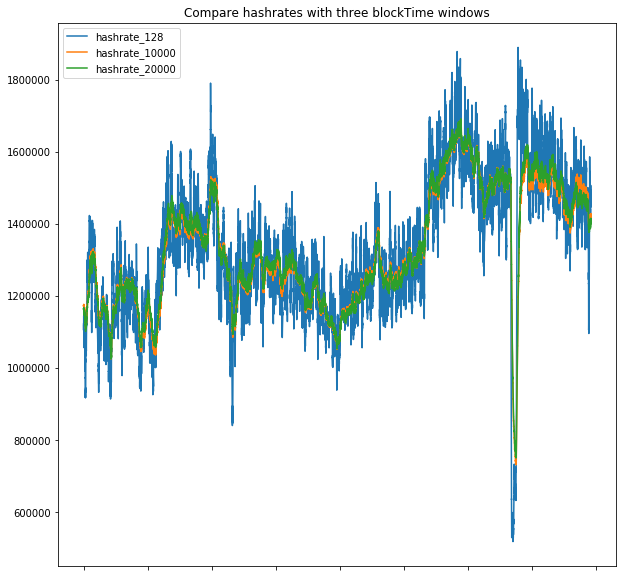

In [7]:

df_blocks_per_period ['blockTime_128'] = df_blocks_per_period ['blockTime'].rolling(128).mean()
df_blocks_per_period ['blockTime_256'] = df_blocks_per_period ['blockTime'].rolling(256).mean()
df_blocks_per_period ['blockTime_512'] = df_blocks_per_period ['blockTime'].rolling(512).mean()
df_blocks_per_period ['blockTime_5000'] = df_blocks_per_period ['blockTime'].rolling(5000).mean()
df_blocks_per_period ['blockTime_10000'] = df_blocks_per_period ['blockTime'].rolling(10000).mean()
df_blocks_per_period ['blockTime_20000'] = df_blocks_per_period ['blockTime'].rolling(20000).mean()



df_blocks_per_period ['blocks_128'] = df_blocks_per_period ['blocks_per_min'].rolling(128).mean()
df_blocks_per_period ['blocks_256'] = df_blocks_per_period ['blocks_per_min'].rolling(256).mean()
df_blocks_per_period ['blocks_512'] = df_blocks_per_period ['blocks_per_min'].rolling(512).mean()
df_blocks_per_period = df_blocks_per_period.dropna()

df_blocks_per_period['hashrate_128'] = df_blocks_per_period.apply(lambda x: x['difficulty']/x['blockTime_128'],axis=1)
df_blocks_per_period['hashrate_256'] = df_blocks_per_period.apply(lambda x: x['difficulty']/x['blockTime_256'],axis=1)
df_blocks_per_period['hashrate_512'] = df_blocks_per_period.apply(lambda x: x['difficulty']/x['blockTime_512'],axis=1)
df_blocks_per_period['hashrate_5000'] = df_blocks_per_period.apply(lambda x: x['difficulty']/x['blockTime_5000'],axis=1)
df_blocks_per_period['hashrate_10000'] = df_blocks_per_period.apply(lambda x: x['difficulty']/x['blockTime_10000'],axis=1)
df_blocks_per_period['hashrate_20000'] = df_blocks_per_period.apply(lambda x: x['difficulty']/x['blockTime_20000'],axis=1)


df_blocks_per_period.plot(y=['hashrate_128','hashrate_10000','hashrate_20000'],
                title='Compare hashrates with three blockTime windows',figsize=(10,10))
plt.show()
#print(df_compare)

Let's do some regression analysis, using OLS

In [9]:
import statsmodels.api as sm

df_regress = df_blocks_per_period[['blockTime','nrgConsumed','size','hashrate_512','blocks_per_min','difficulty']]                                  
y = df_regress['blocks_per_min']
X = df_regress[['size','nrgConsumed']]
                                                               
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

model.params

print(df_regress)

       blockTime    nrgConsumed         size  hashrate_512  blocks_per_min  \
19999   7.750000   26250.000000  2154.375000  1.176645e+06               8   
20000  11.500000    7000.000000  1997.000000  1.176030e+06               6   
20001   8.400000       0.000000  1940.000000  1.180503e+06               5   
20002  10.285714       0.000000  1940.000000  1.179363e+06               7   
20003  10.000000   21000.000000  2111.833333  1.180966e+06               6   
20004  12.000000       0.000000  1940.000000  1.180536e+06               3   
20005  15.600000       0.000000  1940.000000  1.178764e+06               5   
20006   8.250000   31500.000000  2196.875000  1.178643e+06               8   
20007  10.833333   17500.000000  2082.666667  1.179214e+06               6   
20008   8.166667    3500.000000  1968.833333  1.179700e+06               6   
20009  10.500000   94500.000000  2707.500000  1.181330e+06               6   
20010   9.714286    3000.000000  1964.714286  1.180462e+06      

RMSE:2.7254819046215508e-14


Text(0,0.5,'Predictions')

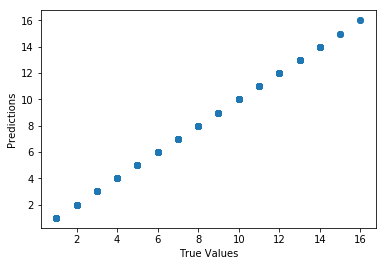

In [74]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
X_train, X_test, y_train, y_test = train_test_split(df_regress, y, test_size=0.3)

lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print("RMSE:{}".format(np.sqrt(metrics.mean_squared_error(y_test, predictions))))


plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")




Therefore we get a formula of:

blocks_per_hour = 0.19(size) - .002(nrgConsumed).

This has an accuracy of RMSE = <.001


Now, lets do cross validation to make sure about the accuracy

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
model = LinearRegression()

# Perform K-fold CV
cross_val_scores = cross_val_score(model, X, y, cv=10,scoring="neg_mean_squared_error")
print(np.mean(cross_val_scores))

-4.875849266217907
